In [1]:
# Core
import numpy as np
import pandas as pd

# Tensorflow / ML
import tensorflow as tf

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Utility
import os
import time

In [2]:
# Set visibible GPU
gpu_num: int = 2
os.environ['CUDA_VISIBLE_DEVICES']=f'{gpu_num}'

In [3]:
# Configure TF GPU growth
import kepler_sieve
from tf_utils import gpu_grow_memory
gpu_grow_memory(verbose=True)

Found 1 GPUs.  Setting memory growth = True.


In [4]:
# MSE Imports
from asteroid_element import load_ast_elt
from candidate_element import asteroid_elts, perturb_elts, random_elts, elts_add_mixture_params, elts_add_H
from ztf_ast import load_ztf_nearest_ast, calc_hit_freq
from ztf_element import load_ztf_batch, make_ztf_batch, ztf_score_by_elt, ztf_elt_summary
from asteroid_model import AsteroidPosition, AsteroidDirection, make_model_ast_pos
from asteroid_search_layers import CandidateElements, MixtureParameters, TrajectoryScore
from asteroid_search_model import AsteroidSearchModel
from asteroid_search_report import traj_diff
from nearest_asteroid import nearest_ast_elt_cart, nearest_ast_elt_cov, elt_q_norm
from element_eda import score_by_elt
from asteroid_dataframe import calc_ast_data, spline_ast_vec_df
from astro_utils import deg2dist, dist2deg, dist2sec

In [5]:
# Aliases
keras = tf.keras

# Constants
dtype = tf.float32
dtype_np = np.float32
space_dims = 3

In [6]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

## Load ZTF Data and Batch of Orbital Elements

In [7]:
# Load orbital elements for known asteroids
ast_elt = load_ast_elt()

# Number of asteroids
N_ast = ast_elt.shape[0]

In [8]:
# Load ztf nearest asteroid data
ztf_ast = load_ztf_nearest_ast()

In [9]:
# Asteroid numbers and hit counts
ast_num, hit_count = calc_hit_freq(ztf=ztf_ast, thresh_sec=2.0)

# Sort the hit counts in descending order and find the top batch_size
idx = np.argsort(hit_count)[::-1]

# Extract the asteroid number and hit count for this batch
ast_num_best = ast_num[idx]
hit_count_best = hit_count[idx]

In [10]:
# Parameters to build elements batch
batch_size = 64

# Batch of unperturbed elements
elts_ast = asteroid_elts(ast_nums=ast_num_best[0:batch_size])

In [11]:
# # Review unperturbed elements
# elts_ast

In [12]:
# Inputs to perturb elements: small
sigma_a = 0.01
sigma_e = 0.0025
sigma_inc_deg = 0.05
sigma_f_deg = 0.25
sigma_Omega_deg = 0.25
sigma_omega_deg = 0.25
mask_pert = None
random_seed = 42

In [13]:
# Perturb orbital elements
elts_pert= perturb_elts(elts_ast, sigma_a=sigma_a, sigma_e=sigma_e, 
                    sigma_inc_deg=sigma_inc_deg, sigma_f_deg=sigma_f_deg, 
                    sigma_Omega_deg=sigma_Omega_deg, sigma_omega_deg=sigma_omega_deg,
                    mask_pert=mask_pert, random_seed=random_seed)

In [14]:
# Choose which elements to search on
elts = elts_pert

In [15]:
# # Search for nearest asteroids to these elements
# elts_near = nearest_ast_elt(elts)

In [16]:
# Review selected initial candidate elements, including the nearest asteroid information
# elts

In [17]:
# Review nearest asteroid to these candidate elements
# elts_near

In [18]:
# How many elements are still closest to the original elements?
# np.sum(elts.nearest_ast_num == elts.element_id)

## Batches of ZTF Data Near Initial Candidate Elements

In [19]:
# Arguments to make_ztf_batch
thresh_deg = 2.0
near_ast = False
regenerate = False

In [20]:
# Load perturbed element batch
ztf_elt = load_ztf_batch(elts=elts, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [21]:
# Review ZTF elements
ztf_elt

,ztf_id,element_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,mag_app,ux,...,vz,elt_ux,elt_uy,elt_uz,elt_r,s,s_sec,z,v,is_hit
0,53851,733,b'ZTF18abnothj',594197584815010004,5501,58348.197581,266.229165,-13.513802,16.755600,-0.063945,...,0.004058,-0.041592,-0.981941,0.184561,2.234762,0.025900,5342.395278,0.999665,0.550588,False
1,73604,733,b'ZTF18ablwzmb',594197584815015003,5501,58348.197581,265.761024,-13.509148,16.035999,-0.071871,...,0.004058,-0.041592,-0.981941,0.184561,2.234762,0.033026,6812.476092,0.999455,0.895261,False
2,82343,733,b'ZTF18abiydvm',635193253015015018,12089,58389.193252,270.331454,-11.244934,17.196199,0.005674,...,0.003801,0.012795,-0.977103,0.212383,2.702320,0.007222,1489.642347,0.999974,0.042810,False
3,82356,733,b'ZTF18abfivlq',580301301415015008,4298,58334.301308,269.895080,-12.887404,18.069599,-0.001785,...,0.004122,-0.020236,-0.985475,0.168609,2.108963,0.023598,4867.556965,0.999722,0.457068,False
4,82357,733,b'ZTF18abfivlq',580340131415015012,4342,58334.340139,269.895074,-12.887407,15.471100,-0.001785,...,0.004122,-0.020329,-0.985464,0.168661,2.109275,0.023637,4875.610226,0.999721,0.458582,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315312,5651017,324582,b'ZTF20aaqvkiv',1150185310015015007,96634,58904.185313,43.164491,30.568791,19.821800,0.628021,...,-0.001586,0.620235,0.757066,0.205329,2.936159,0.031535,6504.889092,0.999503,0.816249,False
315313,5651103,324582,b'ZTF20aaqvkiu',1150185310015015006,96634,58904.185313,42.979527,30.566971,19.499599,0.629931,...,-0.001586,0.620235,0.757066,0.205329,2.936159,0.033577,6926.136324,0.999436,0.925381,False
315314,5651180,324582,b'ZTF20aaqvkur',1150185310315015001,96634,58904.185313,42.969119,30.230791,18.551399,0.632210,...,-0.001586,0.620235,0.757066,0.205329,2.936159,0.030243,6238.306185,0.999543,0.750722,False
315315,5651234,324582,b'ZTF20aaqvkyr',1150185754815015006,96635,58904.185752,42.384302,29.148349,18.648100,0.645100,...,-0.001586,0.620233,0.757067,0.205329,2.936165,0.034777,7173.582036,0.999395,0.992676,False


In [22]:
# Score by element - perturbed
score_by_elt = ztf_score_by_elt(ztf_elt)

In [23]:
# Summarize the ztf element batch: perturbed asteroids
ztf_elt_summary(ztf_elt, score_by_elt, 'Perturbed Asteroids')

ZTF Element Dataframe Perturbed Asteroids:
                  Total     (Per Batch)
Observations   :   315317   (     4927)

Summarize score = sum(-1.0 - log(v)) by batch.  (Mean=0, Variance=num_obs)
Mean score     :     252.73
Sqrt(batch_obs):      70.19
Mean t_score   :       3.71


In [24]:
# Mixture parameters
num_hits: int = 10
R_deg: float = 0.5

In [25]:
# Add mixture parameters to candidate elements
elts_add_mixture_params(elts=elts, num_hits=num_hits, R_deg=R_deg, thresh_deg=thresh_deg)

In [26]:
# Add brightness parameter H
elts_add_H(elts=elts)

In [27]:
# Review perturbed elements; includes nearest asteroid number and distance
elts

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R,thresh_s,H,sigma_mag
0,51921,2.682597,0.217803,0.499641,4.705231,2.451220,-1.132557,58600.0,10,0.008727,0.034905,16.5,4.0
1,59244,2.631087,0.263394,0.464606,5.735210,1.769592,-1.606798,58600.0,10,0.008727,0.034905,16.5,4.0
2,15786,1.895464,0.047647,0.391007,6.136626,0.801253,-1.245314,58600.0,10,0.008727,0.034905,16.5,4.0
3,3904,2.595620,0.098526,0.261602,5.453543,2.211553,-1.355664,58600.0,10,0.008727,0.034905,16.5,4.0
4,142999,2.613817,0.191549,0.513090,0.233977,0.942074,-1.303158,58600.0,10,0.008727,0.034905,16.5,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,11952,2.241410,0.085789,0.117903,0.042534,2.901296,-3.012575,58600.0,10,0.008727,0.034905,16.5,4.0
60,134815,2.600280,0.141038,0.513184,0.275664,0.641888,-0.948576,58600.0,10,0.008727,0.034905,16.5,4.0
61,27860,2.614547,0.096713,0.199311,5.540046,3.263431,3.953275,58600.0,10,0.008727,0.034905,16.5,4.0
62,85937,2.316521,0.196779,0.438674,5.281107,3.200757,3.941057,58600.0,10,0.008727,0.034905,16.5,4.0


## Build Asteroid Search Model

In [28]:
# Observatory for ZTF data is Palomar Mountain
site_name = 'palomar'

In [29]:
# Training parameters
learning_rate = 2.0**-12
clipnorm = 1.0
optimizer_type = 'adam'

In [30]:
# Build asteroid search model
model = AsteroidSearchModel(
                elts=elts, ztf_elt=ztf_elt, 
                site_name=site_name, thresh_deg=thresh_deg, 
                learning_rate=learning_rate, clipnorm=clipnorm,
                file_name=f'candidate_elt_pert_small_{random_seed:04d}.h5',
                name='model')

In [31]:
# Report before training starts
model.report()


Good elements (hits >= 5):   0.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:      nan  :    nan :      nan :      nan
Mean Bad :     0.90  :   0.00 :  1799.79 :  7200.00
Mean     :     0.90  :   0.00 :  1799.79 :  7200.00
Median   :     0.57  :   0.00 :  1792.82 :  7200.00
GeoMean  :     1.36  :   0.00 :  1799.78 :  7200.99
Min      :    -1.55  :   0.00 :  1792.82 :  7200.00
Max      :     6.06  :   0.00 :  1807.21 :  7200.00
Trained for 0 batches over 0 epochs and 0 episodes (elapsed time 0 seconds).


/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [32]:
# model.load()

In [33]:
# model.report()

## Automated Training with Sieve Method

In [34]:
model.sieve()


********************************************************************************
Round 1: 512 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 7200.0
********************************************************************************

Training episode 0: Epoch    0, Batch      0
effective_learning_rate=2.441e-04, training_time 0 sec.
Train on 4096 samples
Epoch 1/4
4096/4096 [==============================] - 3s 790us/sample - loss: -259035.2068
Epoch 2/4
4096/4096 [==============================] - 1s 305us/sample - loss: -445190.7954
Epoch 3/4
4096/4096 [==============================] - 1s 314us/sample - loss: -790247.8330
Epoch 4/4
4096/4096 [==============================] - 1s 317us/sample - loss: -1507325.9375
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:   1447.00 :  1447.00 :      nan arc seconds
Geom Mean Threshold :   7200.00 :  7200.00 :      nan arc seconds
Mean Log Likelihood :      4.74 :     4.74 :      nan
Mean Hits           :     

In [ ]:
# model.load()

In [35]:
model.report()


Good elements (hits >= 5):  42.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:   798.24  : 117.50 :    36.06 :   779.79
Mean Bad :    42.97  :   0.64 :   266.21 :  2374.53
Mean     :   538.62  :  77.33 :   115.17 :  1327.98
Median   :   743.18  :  65.50 :    41.23 :   806.35
GeoMean  :   218.79  :  20.01 :    42.97 :   934.96
Min      :     4.12  :   0.00 :     1.85 :   181.13
Max      :  1278.55  : 189.00 :   751.76 :  2400.00
Trained for 15552 batches over 243 epochs and 105 episodes (elapsed time 751 seconds).


## Review Results Graphically

In [ ]:
# model.load()

In [36]:
model.report()


Good elements (hits >= 5):  42.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:   798.24  : 117.50 :    36.06 :   779.79
Mean Bad :    42.97  :   0.64 :   266.21 :  2374.53
Mean     :   538.62  :  77.33 :   115.17 :  1327.98
Median   :   743.18  :  65.50 :    41.23 :   806.35
GeoMean  :   218.79  :  20.01 :    42.97 :   934.96
Min      :     4.12  :   0.00 :     1.85 :   181.13
Max      :  1278.55  : 189.00 :   751.76 :  2400.00
Trained for 15552 batches over 243 epochs and 105 episodes (elapsed time 751 seconds).


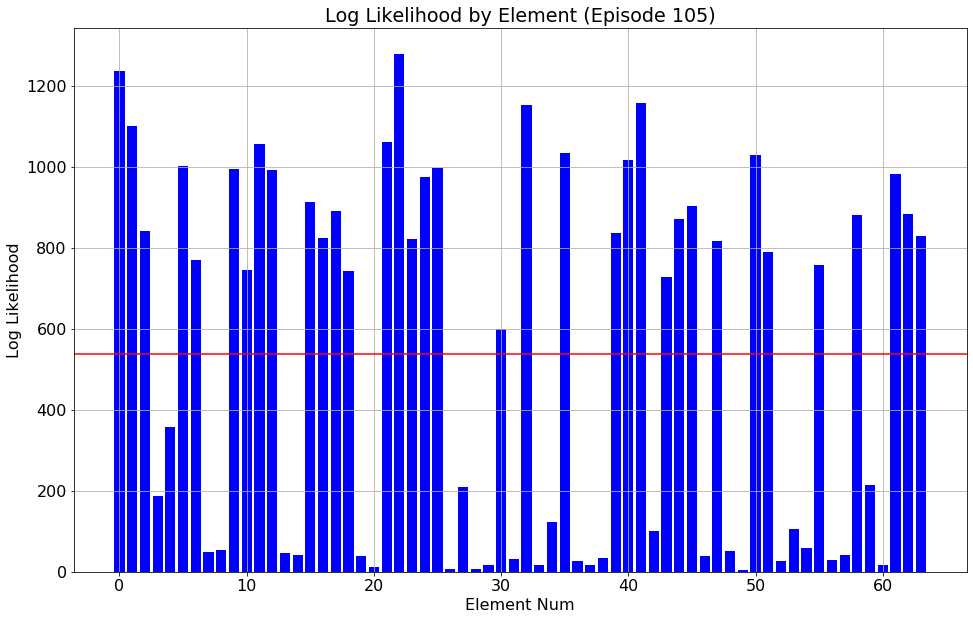

In [37]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('log_like', sorted=False)

In [38]:
fig.savefig('../figs/search_known/perturbed_small/log_like.png', bbox_inches='tight')

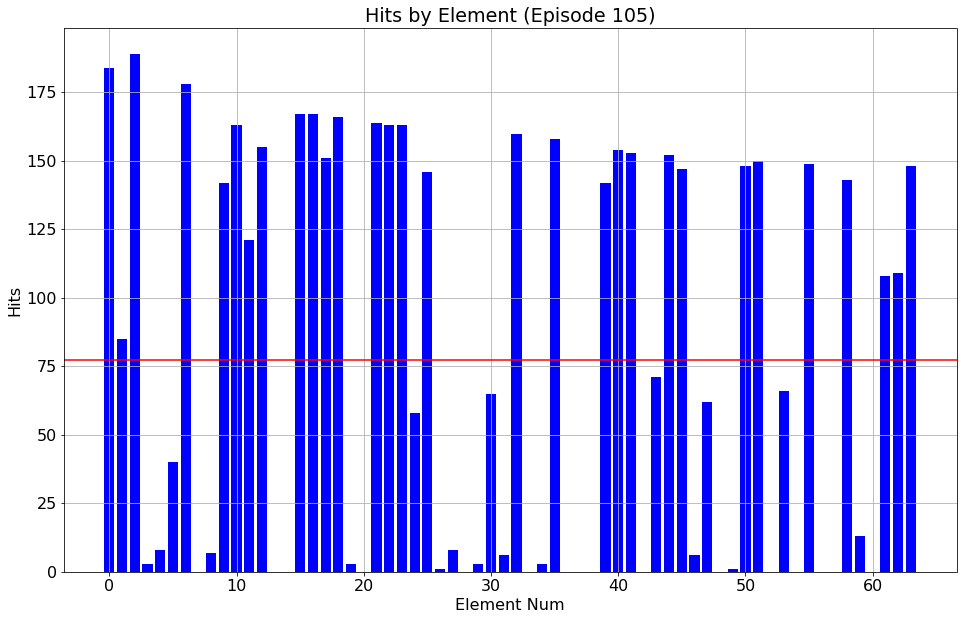

In [39]:
# Bar chart: hits
fig, ax_hits = model.plot_bar('hits', sorted=False)

In [40]:
fig.savefig('../figs/search_known/perturbed_small/hits.png', bbox_inches='tight')

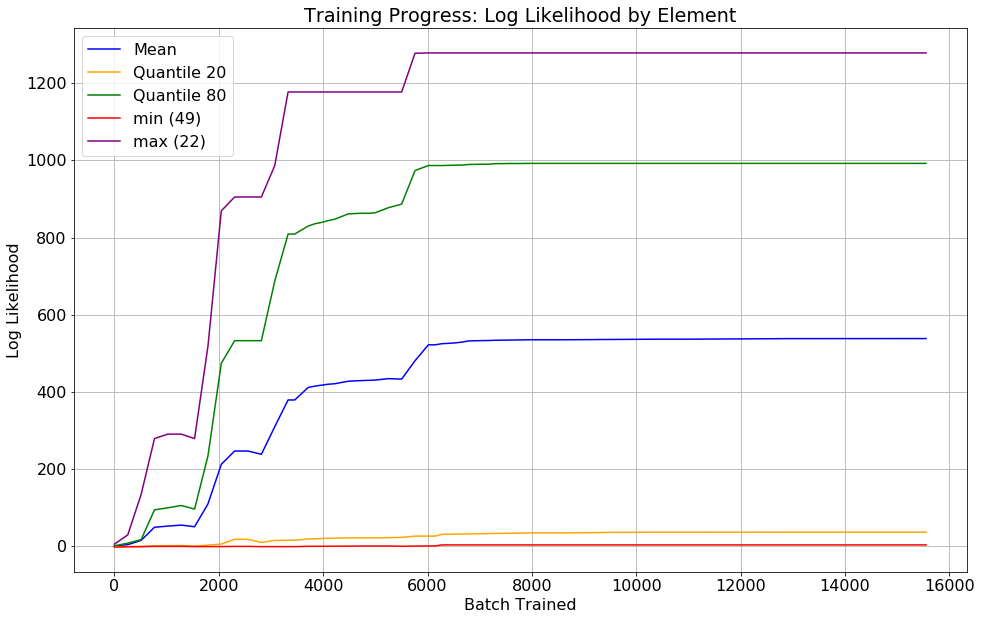

In [41]:
# Learning curve: log likelihood
fig, ax_lc_like = model.plot_hist('log_like')

In [42]:
fig.savefig('../figs/search_known/perturbed_small/learning_curve_log_like.png', bbox_inches='tight')

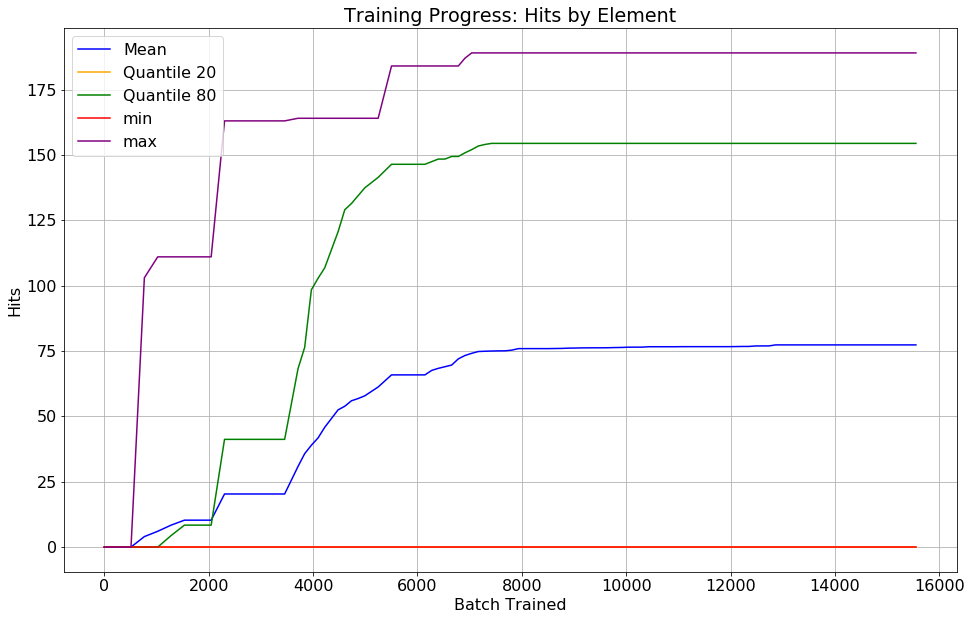

In [43]:
# Learning curve: hits
fig, ax_lc_hits = model.plot_hist('hits')

In [44]:
fig.savefig('../figs/search_known/perturbed_small/learning_curve_hits.png', bbox_inches='tight')

## Distance vs. Nearest Asteroid for Fitted Elements

In [45]:
elts_fit, elts_near = model.nearest_ast()

In [46]:
# model.save_state()

In [48]:
# Review asteroids nearest to the fitted elements
cols = ['element_id', 'log_like', 'hits', 'R_sec', 'thresh_sec', 'nearest_ast_num', 'nearest_ast_dist', 'nearest_ast_q_norm']

# Summary
has_hits = (model.elts_fit.hits >= 5)
is_converged = has_hits
num_converged = np.sum(is_converged)

# Mean on converged
mean_hits = np.mean(model.elts_fit.hits[is_converged])
mean_R_sec = np.exp(np.mean(np.log(model.elts_fit.R_sec[is_converged])))
err_cart_mean = np.mean(model.elts_near_ast.nearest_ast_dist[is_converged])
err_cart_geo = np.exp(np.mean(np.log(model.elts_near_ast.nearest_ast_dist[is_converged])))
err_cov_mean = np.exp(np.mean(np.log(model.elts_near_ast.nearest_ast_q_norm[is_converged])))

# Report
print(f'Good convergence on {num_converged} asteroids.')
print(f'Mean on converged asteroids:')
print(f'Number of hits         : {mean_hits:5.2f}')
print(f'Resolution in arc sec  : {mean_R_sec:5.2f}')
# print(f'Mean Distance in AU    : {err_cart_mean:5.2e}')
print(f'GeoMean Distance in AU : {err_cart_geo:5.2e}')
print(f'Covariance norm        : {err_cov_mean:5.2e}')

Good convergence on 42 asteroids.
Mean on converged asteroids:
Number of hits         : 117.50
Resolution in arc sec  : 18.20
GeoMean Distance in AU : 2.58e-04
Covariance norm        : 1.22e-02


In [49]:
# Review good matches
model.elts_fit[cols][is_converged].sort_values(by=['hits', 'R_sec'], ascending=[False, True])

,element_id,log_like,hits,R_sec,thresh_sec,nearest_ast_num,nearest_ast_dist,nearest_ast_q_norm
2,15786,840.716492,189.0,51.446018,1318.764160,15786,0.000053,0.006252
0,51921,1235.945435,184.0,7.020611,354.438202,51921,0.000439,0.006395
6,1803,770.687317,178.0,42.523010,576.097412,1803,0.000130,0.010585
15,59245,913.723938,167.0,10.212344,241.662796,59245,0.000136,0.001910
16,48453,825.454956,167.0,32.504261,631.649048,48453,0.000080,0.003100
18,4133,742.013855,166.0,46.042126,1229.199585,4133,0.000162,0.001359
21,77774,1061.667847,164.0,3.870716,187.415222,77774,0.000186,0.008072
22,9229,1278.548218,163.0,1.854969,181.128510,9229,0.000078,0.004226
23,49627,822.990601,163.0,21.146221,637.340027,49627,0.000137,0.003884
10,43796,744.348450,163.0,39.943108,556.213135,43796,0.000109,0.023828


In [50]:
# # Review fitted elements including nearest asteroid
# model.elts_fit

In [51]:
# Add nearest_ast_dist column
model.elts_fit['nearest_ast_dist'] = model.elts_near_ast.nearest_ast_dist
model.elts_fit['nearest_ast_q_norm'] = model.elts_near_ast.nearest_ast_q_norm

# Filter for only the good ones
mask = (model.elts_fit.log_like > 200) & (model.elts_fit.R_sec < 40)
cols = ['element_id', 'num_hits', 'R_sec', 'thresh_sec', 'log_like', 'hits', 'nearest_ast_dist', 'nearest_ast_q_norm']
model.elts_fit[cols][mask].sort_values(by='R_sec')

,element_id,num_hits,R_sec,thresh_sec,log_like,hits,nearest_ast_dist,nearest_ast_q_norm
22,9229,162.999969,1.854969,181.128510,1278.548218,163.0,0.000078,0.004226
41,3426,152.966415,3.837524,292.059296,1158.246948,153.0,0.000087,0.018271
21,77774,164.000366,3.870716,187.415222,1061.667847,164.0,0.000186,0.008072
32,19794,160.000946,4.171639,286.836731,1153.404175,160.0,0.000042,0.012092
50,6455,149.987808,4.720953,283.580475,1029.378906,148.0,0.000410,0.004784
40,31539,153.999512,6.448866,295.771393,1016.071289,154.0,0.000097,0.005192
0,51921,193.980881,7.020611,354.438202,1235.945435,184.0,0.000439,0.006395
9,14348,174.977448,7.029789,246.650986,993.730164,142.0,0.000473,0.007210
35,122263,157.975494,8.308047,360.602875,1034.797729,158.0,0.000090,0.003793
62,85937,147.974640,8.528889,351.406006,883.476196,109.0,0.000490,0.011553


In [52]:
# # Filter for incomplete convergence
# mask = (elts_fit.log_like > 200) & (elts_fit.R_sec >= 60)
# elts_fit[mask]

## Visualize Error vs. Nearest Asteroid

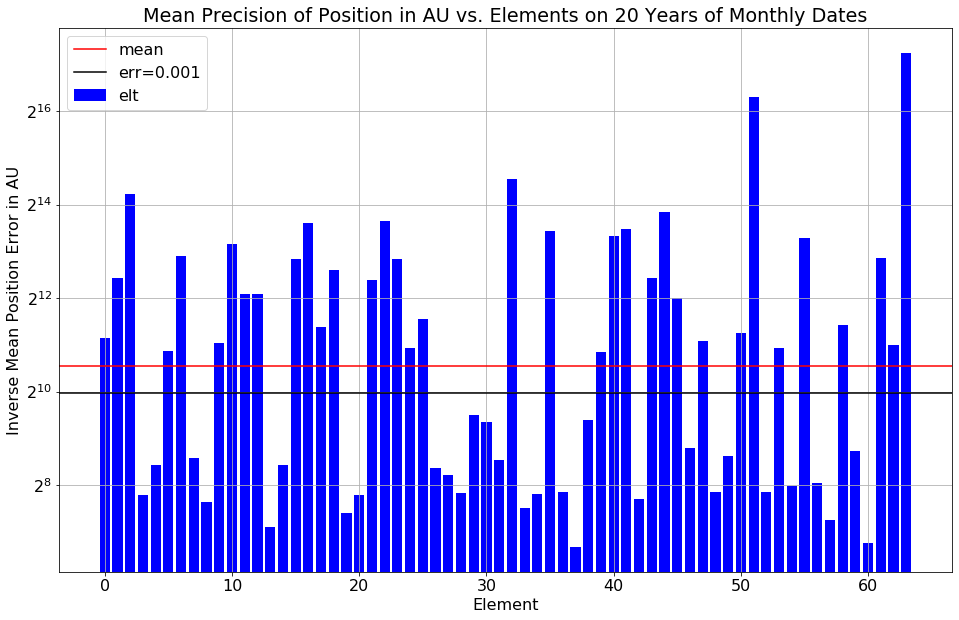

In [53]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(plot_type='cart', is_log=True, use_near_ast_dist=True)

In [54]:
fig.savefig('../figs/search_known/perturbed_small/near_ast_dist.png', bbox_inches='tight')

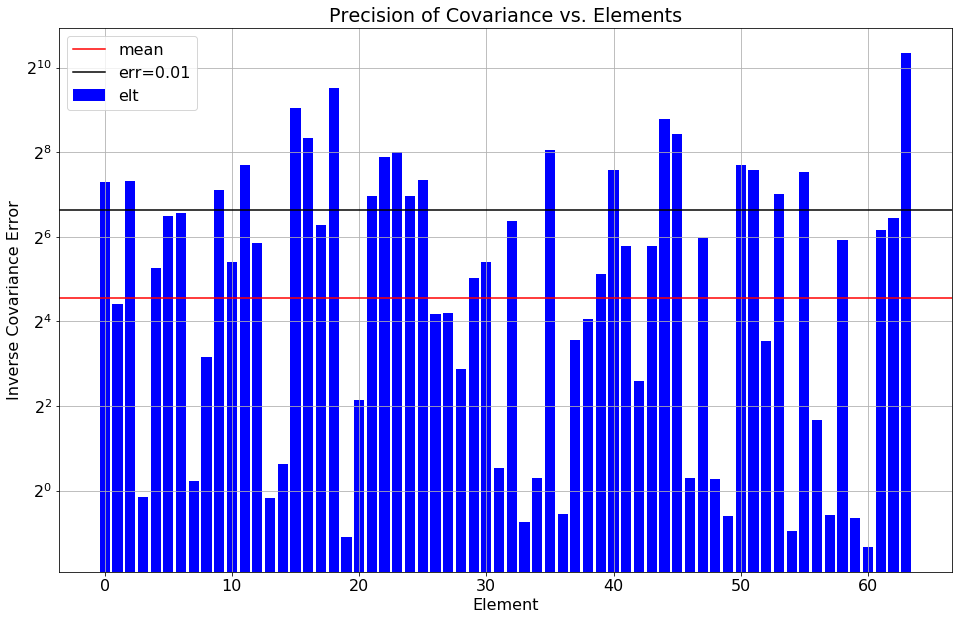

In [55]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(plot_type='cov', is_log=True, use_near_ast_dist=True)

In [56]:
fig.savefig('../figs/search_known/perturbed_small/near_ast_cov.png', bbox_inches='tight')

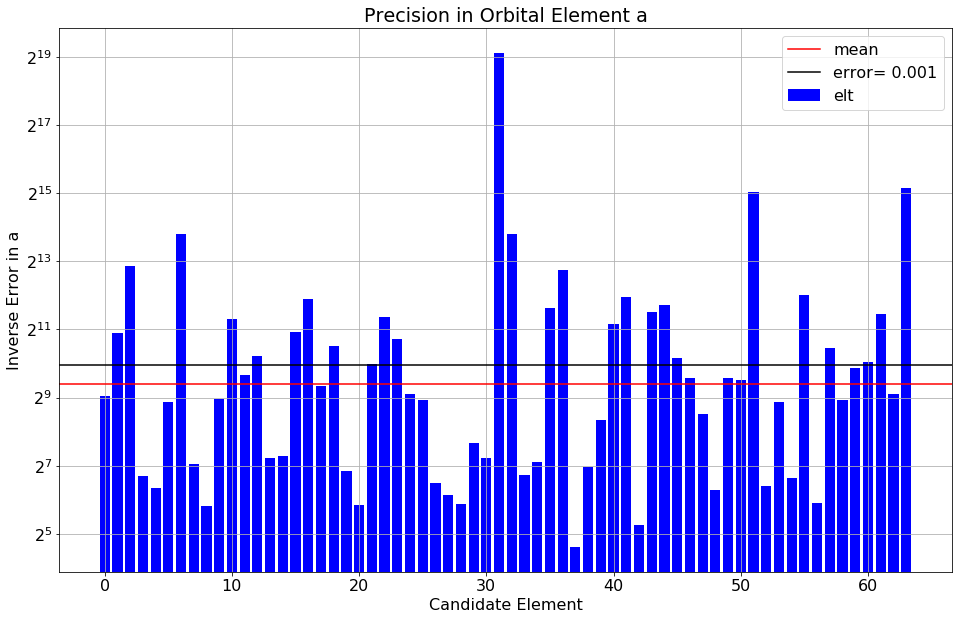

In [57]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='a', is_log=True)

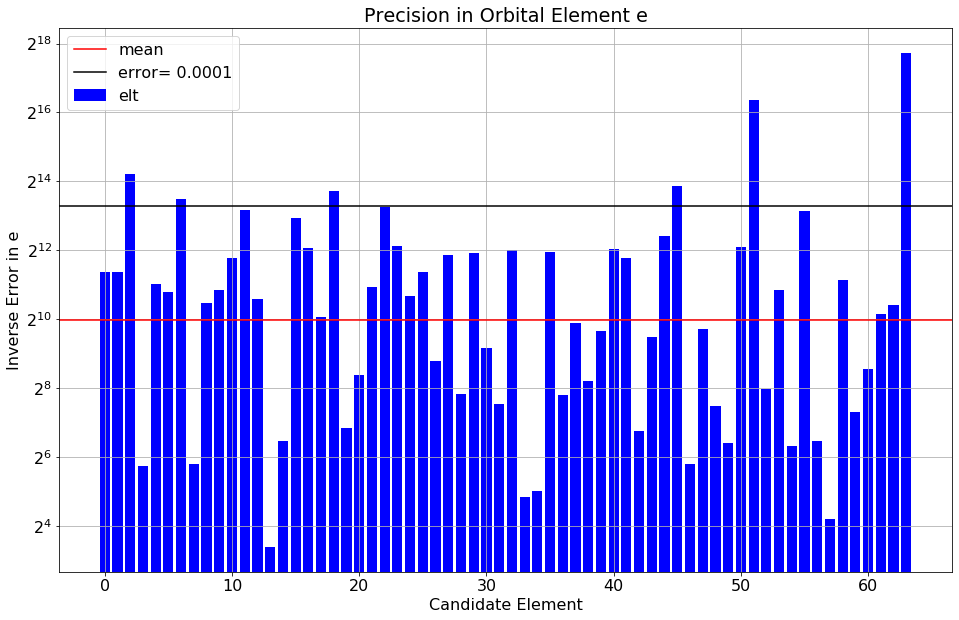

In [58]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='e', is_log=True)

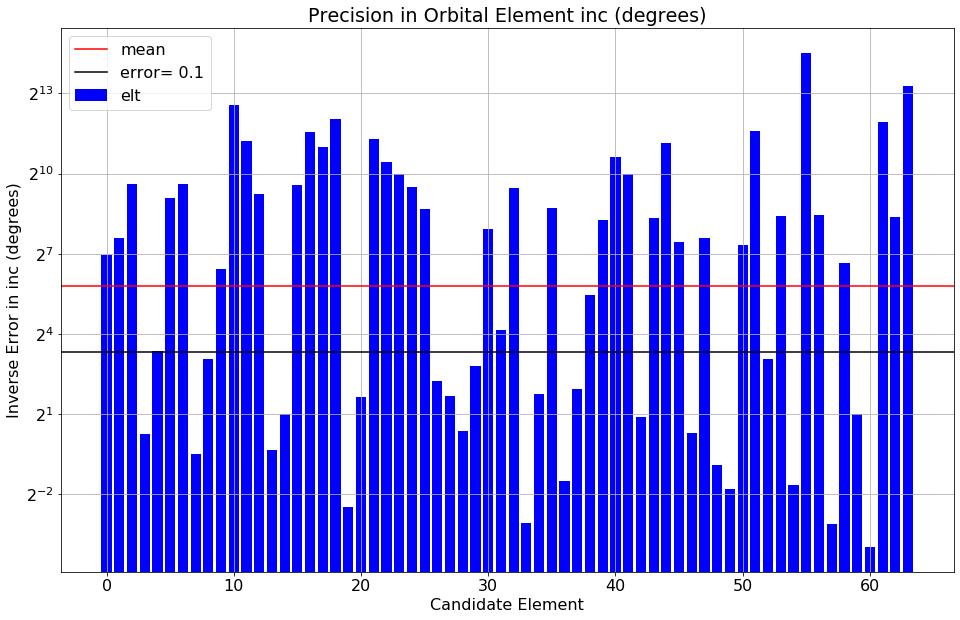

In [59]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='inc', is_log=True)

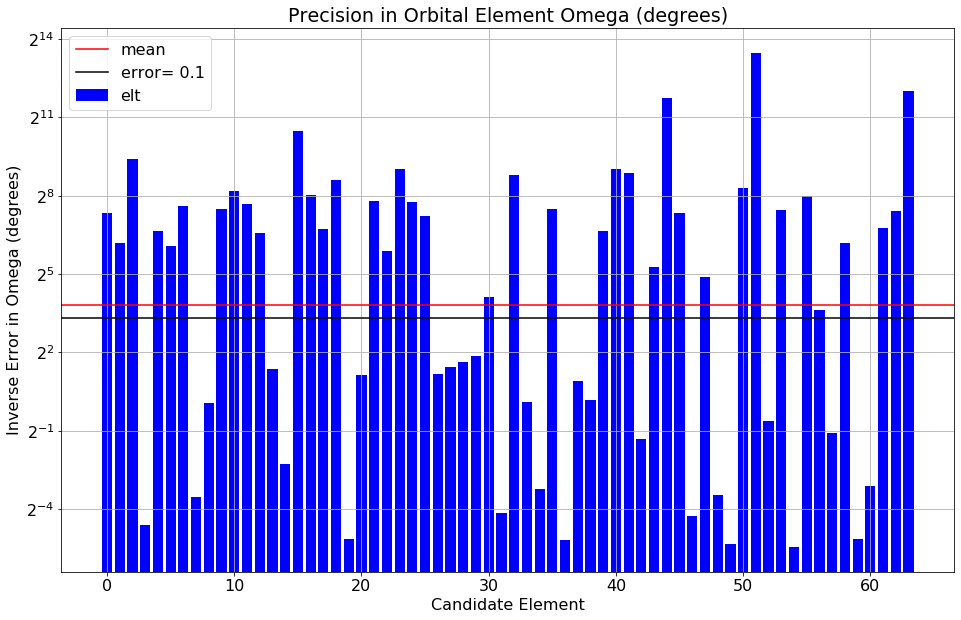

In [60]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='Omega', is_log=True)

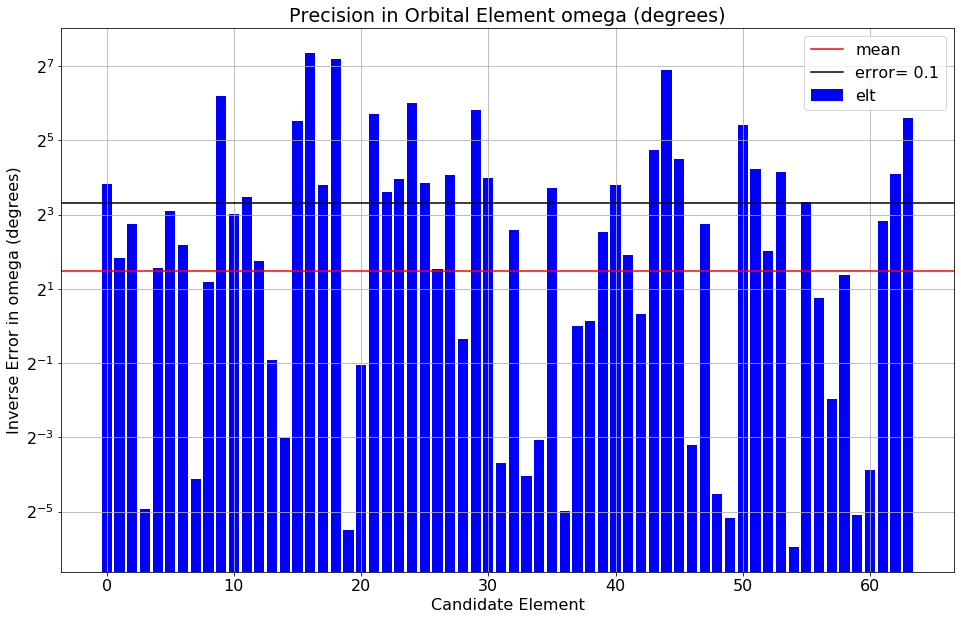

In [61]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='omega', is_log=True)

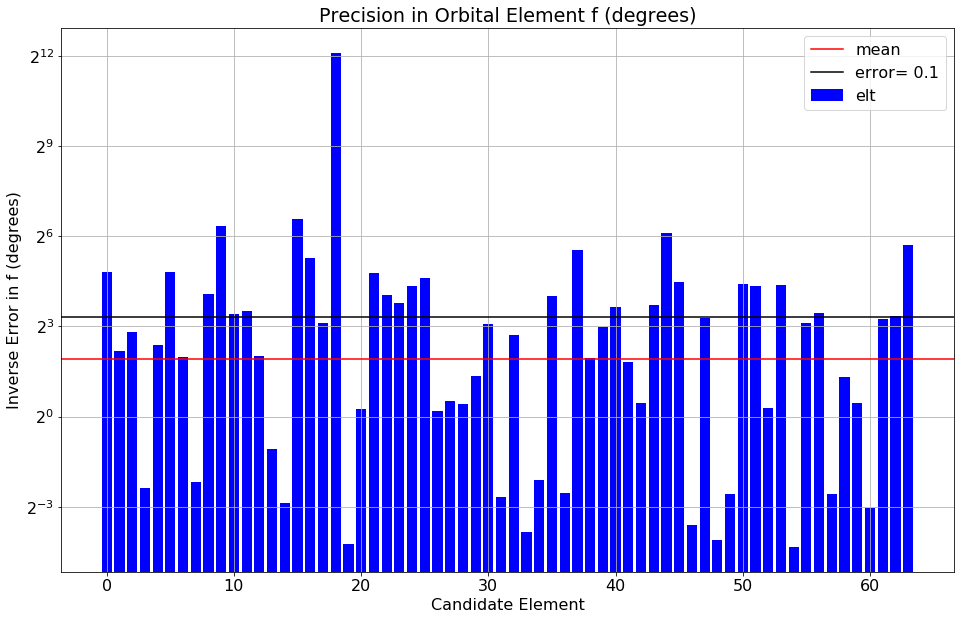

In [62]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='f', is_log=True)